In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

In [2]:
# Load files

# Ratings overview (with selected columns : user_id, beer_id, date, rating, overall, abv)
ratings_overview_rb = pd.read_csv('data/RateBeer/ratings_overview.csv', delimiter=',')
ratings_overview_ba = pd.read_csv('data/BeerAdvocate/ratings_overview.csv', delimiter=',')

# Users
users_rb = pd.read_csv('data/RateBeer/users.csv', delimiter=',')
users_ba = pd.read_csv('data/BeerAdvocate/users.csv', delimiter=',')

# Beers
beers_rb = pd.read_csv('data/RateBeer/beers.csv', delimiter=',')
beers_ba = pd.read_csv('data/BeerAdvocate/beers.csv', delimiter=',')

# Breweries
breweries_rb = pd.read_csv('data/RateBeer/breweries.csv', delimiter=',')
breweries_ba = pd.read_csv('data/BeerAdvocate/breweries.csv', delimiter=',')

C:\Users\annes\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Define the color associated with our project
shade1 = '#fccc1c'
shade2 = '#ddb318'
shade3 = '#bd9915'
shade4 = '#9e8011'
shade5 = '#7e660e'
shade6 = '#5f4d0a'
shade7 = '#3f3307'
shade8 = '#201a03'

rb_color = shade1
ba_color = shade4

### 1. Clean the data

In BeerAdvocate's ratings and users the `user_id` is a string composed of the `user_name` and the `user_id` in the following format : "user_name.user_id"<br>

In [4]:
ratings_overview_ba['user_id'].head()

0           nmann08.184925
1       stjamesgate.163714
2            mdagnew.19527
3    helloloser12345.10867
4          cypressbob.3708
Name: user_id, dtype: object

Therefore, we will split the column to extract the `user_id`.<br>
*Note: we do not need to keep the `user_name` because that information is already contained in the users dataset*
<br><br>
Unfortunately, some ratings only contain the `user_name`, we keep information on those ratings to be able to treat them. 

In [5]:
# Extracting the user_id from BeerAdvocate's ratings
N, D = ratings_overview_ba.shape
str_users_id = ratings_overview_ba['user_id'].astype(str)
new_users_id = list()
missing_id = dict()

print("line num: user_id value --> split user_id")

for i in range(N):
    r = str_users_id[i]
    r_split = r.split('.')
    
    # Print and Store the missing values
    if len(r_split) < 2 or r_split[1] == '':
        print("{:d}: {} --> {}".format(i, r, r_split))
        missing_id[i] = r_split[0]
        new_users_id.append(np.nan)
    
    else:
        new_users_id.append(int(r_split[1]))

line num: user_id value --> split user_id
467624: bros2hoes --> ['bros2hoes']
2893205: bros2hoes --> ['bros2hoes']
5680601: redman414. --> ['redman414', '']
6778138: nan --> ['nan']
8292137: bros2hoes --> ['bros2hoes']


There is only one user of which we know the `user_name` but not the `user_id`. We will look if that information is contained into the users dataframe:

In [6]:
users_ba[users_ba['user_name'].astype(str) == 'bros2hoes']

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location


In [7]:
users_ba[users_ba['user_name'].astype(str) == 'redman414']

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location


Unfortunately, we could not find those users, therefore we won't be able to use their ratings because we cannot rely them to a country. 
<br>
But as we can see above there is only 3 lines for 'bros2hoes' and 1 line for 'redman414' in the ratings. It means that those users only posted respectively 3 and 1 ratings on BeerAdvocate. 
<br>
As we have more than 8 billions of ratings we can say that it won't affect our results.

In [8]:
# Apply the splitted user_id 
ratings_overview_ba['user_id'] = new_users_id

In [9]:
# Extracting the user_id from BeerAdvocate's users
N, D = users_ba.shape
str_users_id = users_ba['user_id'].astype(str)
new_users_id = list()

for i in range(N):
    r = str_users_id[i]
    r_split = r.split('.')
    new_users_id.append(int(r_split[1]))

users_ba['user_id'] = new_users_id

Then there are some values in the `rating` column from BeerAdvocate ratings that don't have a float type.

In [10]:
# We look for the unconvertible values
for i in range(ratings_overview_ba.shape[0]):
    r = ratings_overview_ba['rating'].iloc[i]
    if not type(r) == float:
        try:
            float(r)
        except ValueError:
            print('line {:d}: {:s} could not be converted into float'.format(i, r))

line 6138710: : 4.75
 could not be converted into float
line 7396662: : 2.06
 could not be converted into float


There is only two wrong values we can change them manually

In [11]:
# Suppress manually
ratings_overview_ba['rating'].iloc[6138710] = 4.75
ratings_overview_ba['rating'].iloc[7396662] = 2.06

C:\Users\annes\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
ratings_overview_ba['rating'] = ratings_overview_ba['rating'].astype(float)

Then we just apply small changes that will help us in our analysis :
- Replace the unknown locations (that are represented by nan) by the string 'no_country' so that we can treat all locations as str
- Replace the joined date of the user by a datetime object which is easier to read and understand

In [13]:
# Apply small changes

# Replace nan values in the location by a str
users_rb['location'] = users_rb['location'].fillna('no_country')
users_ba['location'] = users_ba['location'].fillna('no_country')

# Date change
users_rb['joined'] = pd.to_datetime(users_rb['joined'], unit='s')
users_ba['joined'] = pd.to_datetime(users_ba['joined'], unit='s')

### 2. Look for the best country to study

We know that both websites are american, therefore we thought about focusing our researches on US ratings.
First of all, we want to check from which country ratings come from.

In [14]:
# Count the number of ratings per country
def count_ratings_per_country(user_data, ratings_data, verbose=False):
    """
    Args:
        user_data: pd.Dataframe - user df
            must contain 'location' and 'user_id'
        ratings_data: pd.DataFrame - ratings df
            must contain 'user_id'
        
    Returns:
        countries: list[str] - list of the countries
        nbr_ratings_per_country: list[int] - number of ratings per country
            for each i, nbr_ratings_per_country[i] contains the number of ratings from users of the country countries[i]
    """
    countries = user_data.location.unique()
    nbr_ratings_per_country = list()

    for country in countries:
        if verbose:
            print(country, end='\t')
        users_id = user_data.groupby('location').get_group(country)['user_id'].unique()
        cpt = 0

        ratings = ratings_data[ratings_data['user_id'].isin(users_id)]
        cpt += len(ratings)

        nbr_ratings_per_country.append(cpt)
        if verbose:
            print("{:d}".format(cpt))
    return countries, nbr_ratings_per_country

In [15]:
# Count ratings per country in RateBeer
# Lines to run to get the data

#countries_rb, nbr_ratings_per_country_rb = count_ratings_per_country(users_rb, ratings_overview_rb)
#np.save('data/RateBeer/nbr_ratings_per_country.npy', np.array(nbr_ratings_per_country_rb))


# Lines to run when the data as been stored

countries_rb = users_rb.location.unique()
nbr_ratings_per_country_rb = np.load('data/RateBeer/nbr_ratings_per_country.npy')

In [16]:
# Count ratings per country in BeerAdvocate
# Lines to run to get the data

#countries_ba, nbr_ratings_per_country_ba = count_ratings_per_country(users_ba, ratings_overview_ba)
#np.save('data/BeerAdvocate/nbr_ratings_per_country.npy', np.array(nbr_ratings_per_country_ba))


# Lines to run when the data as been stored

countries_ba = users_ba.location.unique()
nbr_ratings_per_country_ba = np.load('data/BeerAdvocate/nbr_ratings_per_country.npy')

In [17]:
# Test if the # of ratings counted are appropriate
print("----RateBeer----")
a = ratings_overview_rb.shape[0]
b = sum(nbr_ratings_per_country_rb)
print(a)
print(b)
print("Number of missing ratings :", a-b)

print("")

print("----BeerAdvocate----")
a = ratings_overview_ba.shape[0]
b = sum(nbr_ratings_per_country_ba)
print(a)
print(b)
print("Number of missing ratings :", a-b)

----RateBeer----
7122074
7122050
Number of missing ratings : 24

----BeerAdvocate----
8393032
8393027
Number of missing ratings : 5


In [18]:
# Group the US countries
def group_US(countries, nbr_ratings_per_country):
    """
    Args:
        countries: list[str] - list of countries
        nbr_ratings_per_country: list[int] - number of ratings per country
    
    Hypothesis:
        len(countries) == len(nbr_ratings_per_country)
        
    Returns:
        countries_USagg: list[str] - list of countries with all countries containing the word 'United States' grouped in one
        nbr_ratings_per_country_USagg: list[int] - number of ratings per country with all US countries sum up in one
    """
    nbr_country = len(countries)
    US_i = list()
    
    # Create a list of index of the countries that contain 'United States'
    for i in range(nbr_country):
        c = countries[i]
        if 'United States' in c:
            US_i.append(i)
    
    nbr_ratings_USagg = list()
    countries_USagg = list()
    cpt_US = 0

    # For each country, 
    # if it is in US sum the number of ratngs 
    # else add country and number of ratings to the result lists
    for i in range(nbr_country):
        if i in US_i:
            cpt_US += nbr_ratings_per_country[i]
        else:
            nbr_ratings_USagg.append(nbr_ratings_per_country[i])
            countries_USagg.append(countries[i])
    
    # Add the aggregated 'United States'
    nbr_ratings_USagg.append(cpt_US)
    countries_USagg.append('United States')
    
    return countries_USagg, nbr_ratings_USagg

In [19]:
countries_USagg_rb, nbr_ratings_USagg_rb = group_US(countries_rb, nbr_ratings_per_country_rb)
countries_USagg_ba, nbr_ratings_USagg_ba = group_US(countries_ba, nbr_ratings_per_country_ba)

In [20]:
# Sort the countries by the total number of ratings on both websites
# Except US that we want to plot separately

countries = list(set(countries_USagg_rb[:-1]).union(set(countries_USagg_ba[:-1])))
nbr_country = len(countries)
total_nbr_ratings = np.zeros(nbr_country)

for i in range(nbr_country):
    country = countries[i]
    
    # Add the number of ratings in RateBeer if the country in RateBeer countries
    try:
        irb = countries_USagg_rb.index(country)
        cpt_rb = nbr_ratings_USagg_rb[irb]
    except ValueError:
        cpt_rb = 0
    
    # Add the number of ratings in BeerAdvocate if the country in BeerAdvocate countries
    try:
        iba = countries_USagg_ba.index(country)
        cpt_ba = nbr_ratings_USagg_ba[iba]
    except ValueError:
        cpt_ba = 0
        
    total_nbr_ratings[i] = cpt_rb + cpt_ba

# Sort countries
sorted_index = np.array(total_nbr_ratings).argsort()
sorted_countries = np.array(countries)[sorted_index]

# Create list of number of ratings for each website
sorted_nbr_ratings_rb = list()
sorted_nbr_ratings_ba = list()

for country in sorted_countries:
    try:
        rb = nbr_ratings_USagg_rb[countries_USagg_rb.index(country)]
    except ValueError:
        rb = 0
    sorted_nbr_ratings_rb.append(rb)
    
    try:
        ba = nbr_ratings_USagg_ba[countries_USagg_ba.index(country)]
    except ValueError:
        ba = 0
    sorted_nbr_ratings_ba.append(ba)

Text(0.5, 1.0, 'Number of ratings depending on the country')

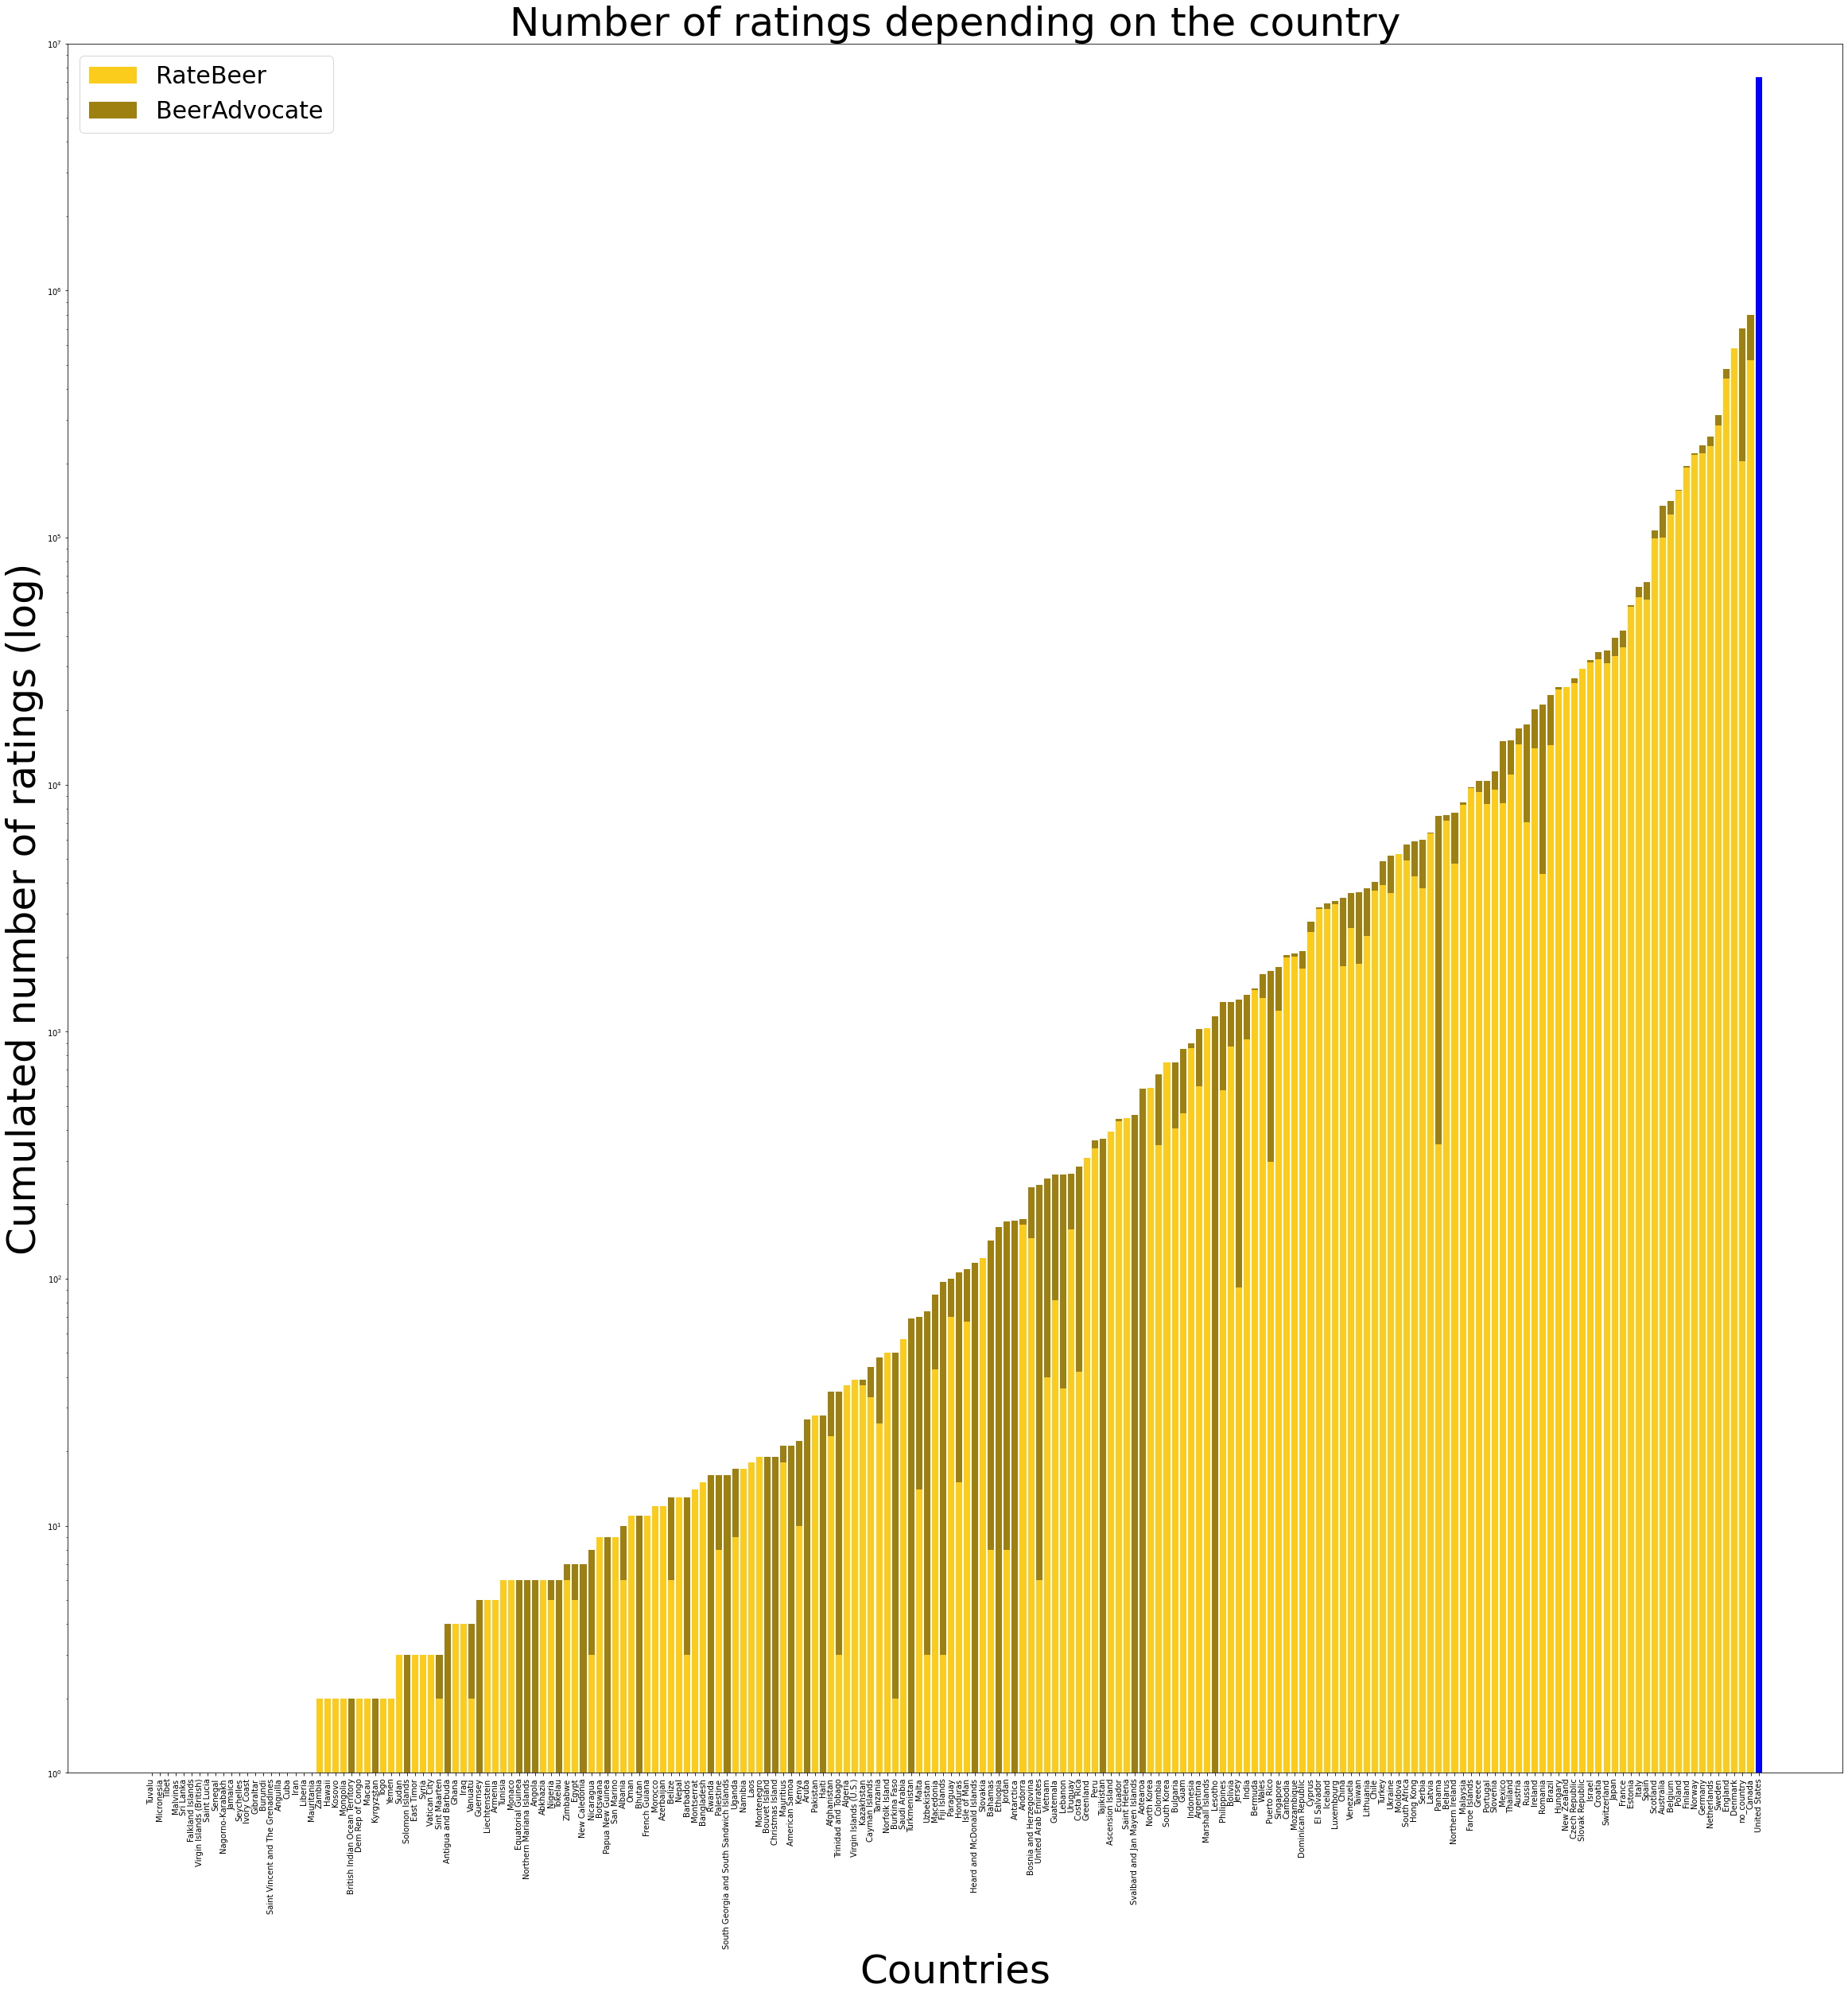

In [21]:
# Plot the distribution
plt.figure(figsize=(40, 40))

# RateBeer
plt.bar(sorted_countries, sorted_nbr_ratings_rb, label='RateBeer', color=rb_color)
plt.bar('United States', nbr_ratings_USagg_rb[-1], color='blue')

# BeerAdvocate
plt.bar(sorted_countries, sorted_nbr_ratings_ba, label='BeerAdvocate', color=ba_color, bottom=sorted_nbr_ratings_rb)
plt.bar('United States', nbr_ratings_USagg_ba[-1], color='blue')

# Legends
plt.yscale('log')
plt.ylim([1,10000000])
plt.xticks(rotation='vertical')
plt.legend(prop={'size':30})
plt.xlabel("Countries", size=50)
plt.ylabel("Cumulated number of ratings (log)", size=50)
plt.title("Number of ratings depending on the country", size=50)

On the above figure we plotted the number of ratings posted in US in blue and the number of ratings for all the other countries in yellow. The y-axis is in logarithmic scale.
<br><br>
We can see that the total number of rating from the US is much higher than in the other countries. There are nearly 10 millions ratings from the US whereas the second country (Canada) only has 1 million. <br> 
Therefore we can use US ratings to perform an interesting analysis. <br>
**In the following analysis we will then focus on US.**

### 3. Extract US ratings

In [22]:
def extract_ratings(user_data, ratings_data, countries):
    """
    Args:
        user_data: pd.DataFrame - users df
            must contain 'user_id', 'location'
        ratings_data: pd.DataFrame - ratings df 
            must contain 'user_id'
        countries: list[str] - list of the countries from which to extract ratings
    
    Return:
        new_ratings: pd.DataFrame - extracted ratings
            has the same columns as ratings_data
    """
    new_ratings = pd.DataFrame()
    
    country_users = np.array(list())
    users_groupby_country = user_data.groupby('location')
    
    for c in countries:
        country_users = np.append(country_users, users_groupby_country.get_group(c)['user_id'].unique())
    
    new_ratings = ratings_data[ratings_data['user_id'].isin(country_users)]
    
    return new_ratings

In [23]:
# Get the US names
# We get the names from both RB and BA in case there are not all written the same way

# For RateBeer
countries_rb = users_rb.location.unique()
US_rb = list()
for c in countries_rb:
    if 'United States' in c:
        US_rb.append(c)

# For BeerAdvocate
countries_ba = users_ba.location.unique()
US_ba = list()
for c in countries_ba:
    if 'United States' in c:
        US_ba.append(c)

In [24]:
# Extract ratings from US in RateBeer
# Lines to run to get the data

#ratings_US_rb = extract_ratings(users_rb, ratings_overview_rb, US_rb)
#ratings_US_rb.to_csv("data/RateBeer/ratings_overview_US.csv")


# Lines to run when the data as been stored

ratings_US_rb = pd.read_csv("data/RateBeer/ratings_overview_US.csv")
ratings_US_rb = ratings_US_rb.rename(columns={"Unnamed: 0":"rating_id"})

In [25]:
# Extract ratings from US in BeerAdvocate
# Lines to run to get the data

#ratings_US_ba = extract_ratings(users_ba, ratings_overview_ba, US_ba)
#ratings_US_ba.to_csv("data/BeerAdvocate/ratings_overview_US.csv")


# Lines to run when the data as been stored

ratings_US_ba = pd.read_csv("data/BeerAdvocate/ratings_overview_US.csv")
ratings_US_ba = ratings_US_ba.rename(columns={"Unnamed: 0":"rating_id"})

In [26]:
# We look for the unconvertible values
for i in range(ratings_US_ba.shape[0]):
    r = ratings_US_ba['rating'].iloc[i]
    if not type(r) == float:
        try:
            float(r)
        except ValueError:
            print('line {:d}: {:s} could not be converted into float'.format(i, r))

#### a. Number of ratings per state

In [27]:
states_rb, ratings_per_state_rb = count_ratings_per_country(users_rb, ratings_US_rb)
states_ba, ratings_per_state_ba = count_ratings_per_country(users_ba, ratings_US_ba)

In [28]:
# Only keep the number of ratings per state as all for all ohter countries the number of ratings will be zero
keep_id_rb = np.where(np.array(ratings_per_state_rb) > 0)
keep_id_ba = np.where(np.array(ratings_per_state_ba) > 0)

states_rb = states_rb[keep_id_rb]
states_ba = states_ba[keep_id_ba]

ratings_per_state_rb = np.array(ratings_per_state_rb)[keep_id_rb]
ratings_per_state_ba = np.array(ratings_per_state_ba)[keep_id_ba]

In [29]:
# Sort the states by the total number of ratings on both websites
states = list(set(states_rb).union(set(states_ba)))
nbr_state = len(states)
total_nbr_ratings = np.zeros(nbr_state)

for i in range(nbr_state):
    state = states[i]
    
    # Add the number of ratings in RateBeer if the state in RateBeer states
    try:
        irb = np.where(states_rb == state)
        cpt_rb = ratings_per_state_rb[irb]
    except ValueError:
        cpt_rb = 0
    
    # Add the number of ratings in BeerAdvocate if the country in BeerAdvocate countries
    try:
        iba = np.where(states_ba == state)
        cpt_ba = ratings_per_state_ba[iba]
    except ValueError:
        cpt_ba = 0
        
    total_nbr_ratings[i] = cpt_rb + cpt_ba

# Sort countries
sorted_index = np.array(total_nbr_ratings).argsort()
sorted_states = np.array(states)[sorted_index]

# Create list of number of ratings for each website
sorted_nbr_ratings_rb = np.array(list())
sorted_nbr_ratings_ba = np.array(list())

for state in sorted_states:
    try:
        rb = ratings_per_state_rb[np.where(states_rb == state)]
    except ValueError:
        rb = 0
    sorted_nbr_ratings_rb = np.append(sorted_nbr_ratings_rb, rb)
    
    try:
        ba = ratings_per_state_ba[np.where(states_ba == state)]
    except ValueError:
        ba = 0
    sorted_nbr_ratings_ba = np.append(sorted_nbr_ratings_ba, ba)

In [30]:
# For clarity in the plot, delete 'United States' in the states names
sorted_states = np.array([str.split(s, ', ')[1] for s in sorted_states])

Text(0.5, 1.0, 'Number of ratings depending on the state')

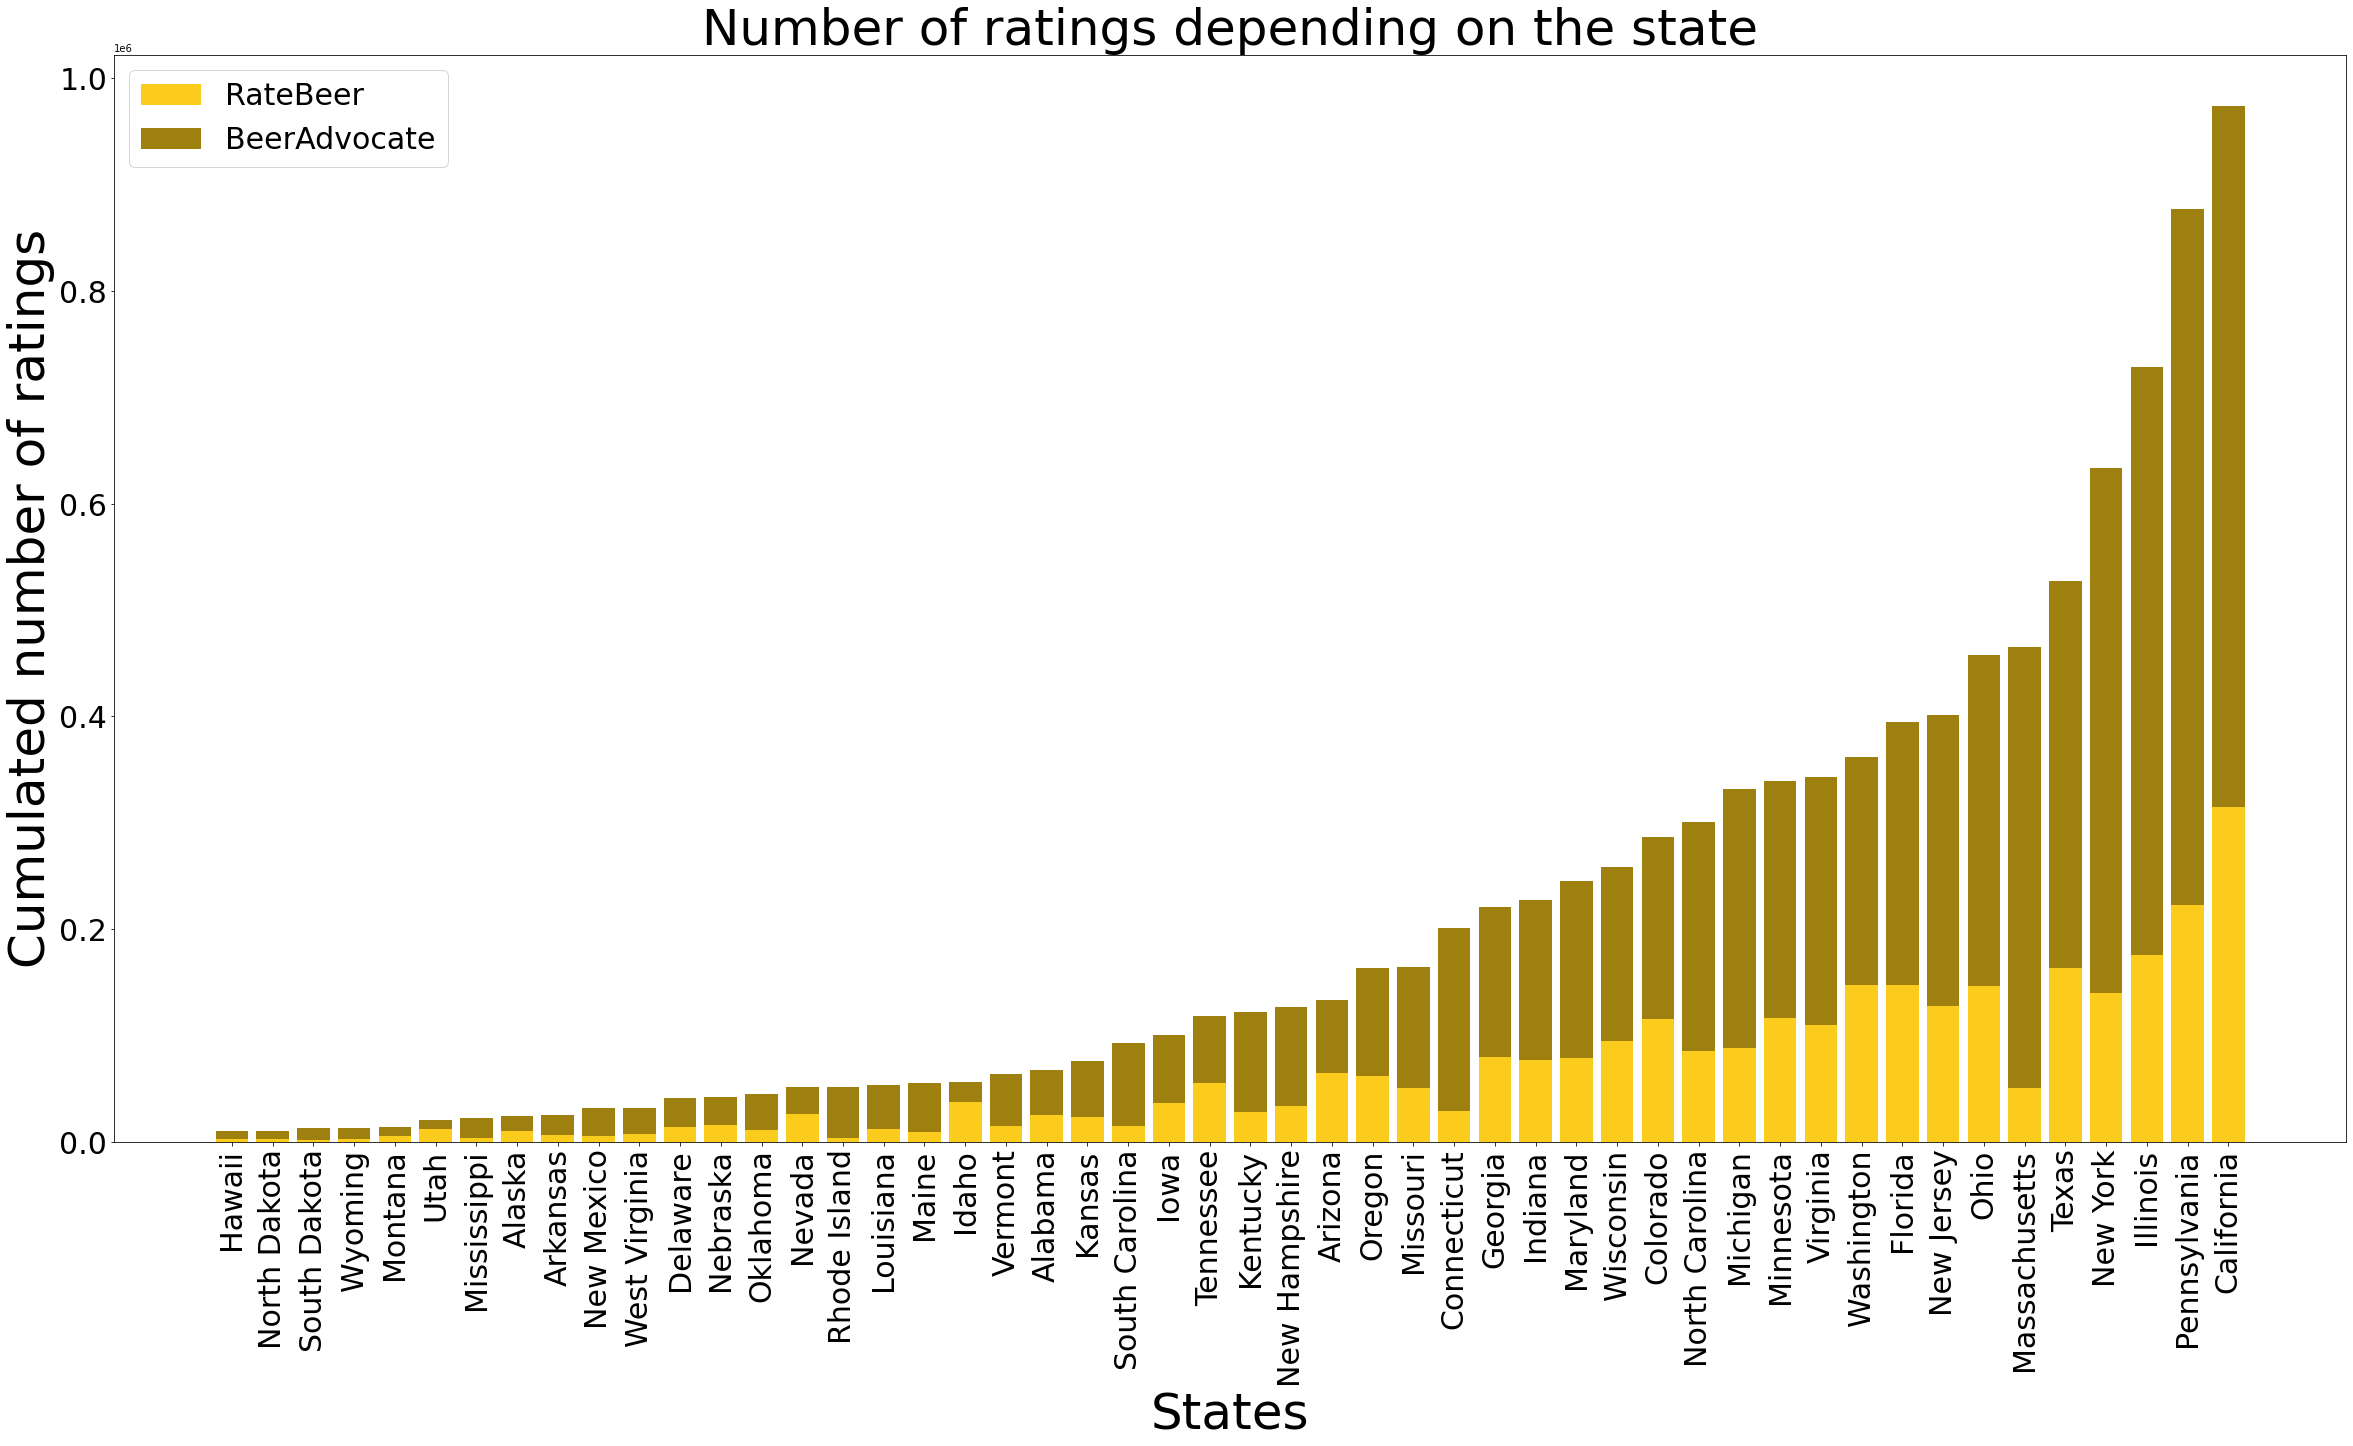

In [31]:
# Plot the distribution
plt.figure(figsize=(40, 20))

# RateBeer
plt.bar(sorted_states, sorted_nbr_ratings_rb, label='RateBeer', color=rb_color)

# BeerAdvocate
plt.bar(sorted_states, sorted_nbr_ratings_ba, label='BeerAdvocate', color=ba_color, bottom=sorted_nbr_ratings_rb)

# Legends
plt.xticks(rotation='vertical')
plt.legend(prop={'size':30})
plt.tick_params(labelsize=30)
plt.xlabel("States", size=50)
plt.ylabel("Cumulated number of ratings", size=50)
plt.title("Number of ratings depending on the state", size=50)

We can see that the number of ratings varies between 10 thousand ratings (Hawaii) and 1 million (California).
We can also see that some a majority of state contain more ratings from BeerAdvocate than from RateBeer.
<br>

#### b. overview per state

In [32]:
# Create a state dataframe
states_overview_df = pd.DataFrame({"state":sorted_states, "nbr_ratings_rb":sorted_nbr_ratings_rb, 
                                   "nbr_ratings_ba":sorted_nbr_ratings_ba})

states_overview_df['total_nbr_ratings'] = states_overview_df['nbr_ratings_rb'] + states_overview_df['nbr_ratings_ba']
states_overview_df = states_overview_df.set_index('state')

In [33]:
states_overview_df.head()

,nbr_ratings_rb,nbr_ratings_ba,total_nbr_ratings
state,,,
Hawaii,2164.0,7897.0,10061.0
North Dakota,2771.0,7828.0,10599.0
South Dakota,1593.0,11709.0,13302.0
Wyoming,2373.0,11016.0,13389.0
Montana,5002.0,8670.0,13672.0


In [34]:
# Split ratings between the states

# Create a dictionnary with all states dataframes
ratings_by_state = dict()

for state in states:
    ratings_by_state[str.split(state, ', ')[1]] = pd.DataFrame()

# Add the splitted ratings from RateBeer
for state in states_rb:
    splitted_state = str.split(state, ', ')[1]
    ratings = extract_ratings(users_rb, ratings_US_rb, [state])
    ratings_by_state[splitted_state] = ratings_by_state[splitted_state].append(ratings)

# add the splitted ratings from BeerAdvocate
for state in states_ba:
    splitted_state = str.split(state, ', ')[1]
    ratings = extract_ratings(users_ba, ratings_US_ba, [state])
    ratings_by_state[splitted_state] = ratings_by_state[splitted_state].append(ratings)

##### Plot the repartition of the number of ratings per state

In [35]:
# set the filepath and load
fp = "USA_adm/USA_adm1.shp"
map_df = gpd.read_file(fp)
map_df = map_df.drop(1)

# Create column for the number of ratings
merged = map_df.set_index('NAME_1').join(states_overview_df['total_nbr_ratings'])

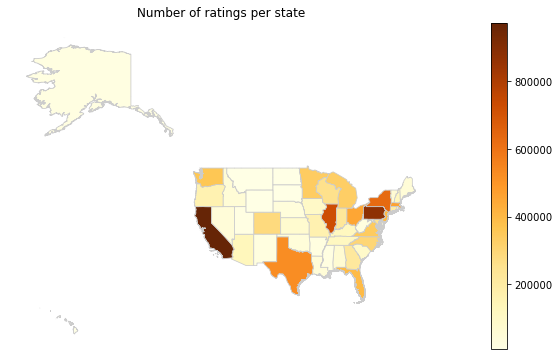

In [36]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'total_nbr_ratings'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['total_nbr_ratings']), max(states_overview_df['total_nbr_ratings'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Number of ratings per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [37]:
# Compute the average ABV per state
average_ABV = np.array(list())

for state in states_overview_df.index:
    state_ratings = ratings_by_state[state]
    average_ABV = np.append(average_ABV, state_ratings['abv'].mean())

states_overview_df['average_ABV'] = average_ABV

##### Plot the repartition of the average ABV per state

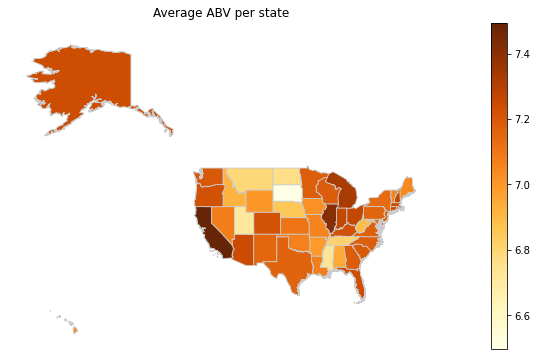

In [38]:
# Create column for the average ABV
merged = map_df.set_index('NAME_1').join(states_overview_df['average_ABV'])

# set a variable that will call whatever column we want to visualise on the map
variable = 'average_ABV'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['average_ABV']), max(states_overview_df['average_ABV'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Average ABV per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [39]:
# Compute the average overall per state
average_overall = np.array(list())

for state in states_overview_df.index:
    state_ratings = ratings_by_state[state]
    average_overall = np.append(average_overall, state_ratings['overall'].mean())

states_overview_df['average_overall'] = average_overall

##### Plot the repartition of the average overall score per state

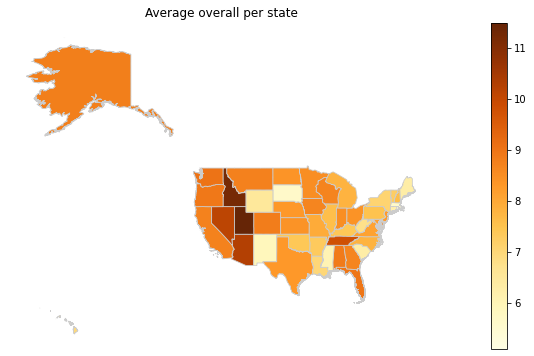

In [40]:
# Create column for the average ABV
merged = map_df.set_index('NAME_1').join(states_overview_df['average_overall'])

# set a variable that will call whatever column we want to visualise on the map
variable = 'average_overall'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['average_overall']), max(states_overview_df['average_overall'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Average overall per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [41]:
# Compute the average rating per state
average_rating = np.array(list())

for state in states_overview_df.index:
    state_ratings = ratings_by_state[state]
    average_rating = np.append(average_rating, state_ratings['rating'].mean())

states_overview_df['average_rating'] = average_rating

##### Plot the repartition of the average rating score per state

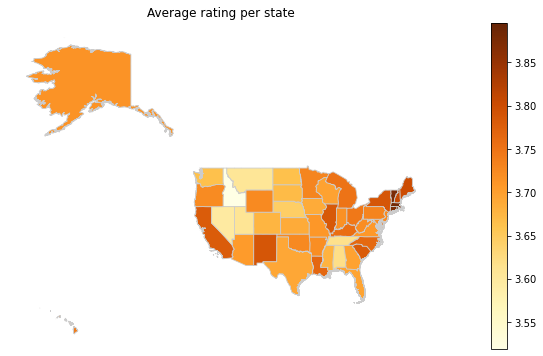

In [42]:
# Create column for the average ABV
merged = map_df.set_index('NAME_1').join(states_overview_df['average_rating'])

# set a variable that will call whatever column we want to visualise on the map
variable = 'average_rating'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['average_rating']), max(states_overview_df['average_rating'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Average rating per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [50]:
# Compute the number of breweries per state
nbr_breweries = np.array(list())

location_breweries_rb = breweries_rb.groupby('location')
location_breweries_ba = breweries_ba.groupby('location')

for state in states_overview_df.index:
    complete_state = 'United States, ' + state
    cpt_rb = location_breweries_rb.get_group(complete_state).shape[0]
    cpt_ba = location_breweries_ba.get_group(complete_state).shape[0]
    nbr_breweries = np.append(nbr_breweries, cpt_rb + cpt_ba)

states_overview_df['nbr_breweries'] = nbr_breweries

##### Plot the number of breweries per state

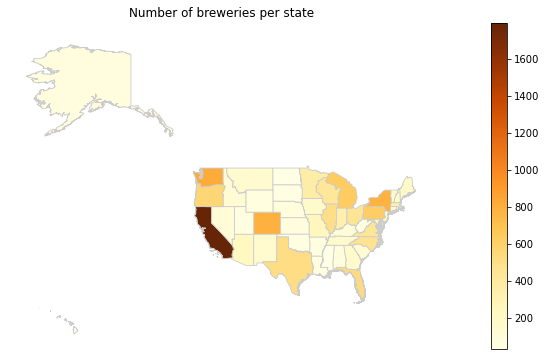

In [53]:
# Create column for the average ABV
merged = map_df.set_index('NAME_1').join(states_overview_df['nbr_breweries'])

# set a variable that will call whatever column we want to visualise on the map
variable = 'nbr_breweries'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['nbr_breweries']), max(states_overview_df['nbr_breweries'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Number of breweries per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

### 4. Explore the evolution of the number of breweries across time

We want to study which breweries received ratings across time. To do so we want to divide the ratings depending on the time they were posted. In a first step we will split them by year. And we will analyse how many breweries received ratings and where they come from to see if some states' breweries are more popular than another. We will compare the number of breweries rated in the state to the total number of breweries.

In [70]:
ratings_US_rb['year'] = ratings_US_rb['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year)
ratings_US_ba['year'] = ratings_US_ba['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year)

In [75]:
ratings_US_rb_groupby_year = ratings_US_rb.groupby('year')
ratings_US_ba_groupby_year = ratings_US_ba.groupby('year')

In [101]:
# Count the number of ratings per brewery each year
states = list(set(states_rb).union(set(states_ba)))
breweries_US_rb = breweries_rb[breweries_rb['location'].isin(states)]

breweries_ratings_by_year_rb = breweries_US_rb[['id', 'location']]

min_year = ratings_US_rb['year'].min()
max_year = ratings_US_rb['year'].max()

for y in range(min_year, max_year+1):
    ratings_year = ratings_US_rb_groupby_year.get_group(y)
    cpt_ratings = np.array(list())
    
    for bi in breweries_ratings_by_year_rb['id']:
        # Get the beer ids
        beer_ids = beers_rb[beers_rb['brewery_id'] == bi]['beer_id'].unique()
        
        # Count the number of ratings realted to this brewery
        cpt = ratings_year[ratings_year['beer_id'].isin(beer_ids)].shape[0]
        
        # Add the count
        cpt_ratings = np.append(cpt_ratings, cpt)
    
    # Add the column in the dataframe
    breweries_ratings_by_year_rb['nbr_ratings_' + str(y)] = cpt_ratings

2000


<ipython-input-101-0de2846162c2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breweries_ratings_by_year_rb['nbr_ratings_' + str(y)] = cpt_ratings


2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [111]:
breweries_ratings_by_year_rb_groupby_location = breweries_ratings_by_year_rb.groupby('location')

min_year = ratings_US_rb['year'].min()
max_year = ratings_US_rb['year'].max()

for y in range(min_year, max_year+1):
    percentage_breweries_rated = np.array(list())
    total_nbr_ratings = np.array(list())
    
    # Compute for each state
    for state in states_overview_df.index:
        complete_state = 'United States, ' + state
        
        # Get the number of ratings evolution through years
        breweries_ratings_evolution = breweries_ratings_by_year_rb_groupby_location.get_group(complete_state)
        nbr_breweries = breweries_ratings_evolution.shape[0]
        nbr_ratings_per_brewery = breweries_ratings_evolution['nbr_ratings_' + str(y)]

        # Compute the percentage of breweries rated
        percentage = np.where(nbr_ratings_per_brewery > 0)[0].shape[0] / nbr_breweries
        
        # Count the total nbr of ratings
        cpt = sum(nbr_ratings_per_brewery)
        
        # Add the results in the lists
        percentage_breweries_rated = np.append(percentage_breweries_rated, percentage)
        total_nbr_ratings = np.append(total_nbr_ratings, cpt)
        
    states_overview_df['percentage_breweries_rated_' + str(y)] = percentage_breweries_rated
    states_overview_df['total_nbr_ratings_'+ str(y)] = total_nbr_ratings

In [119]:
states_overview_df.head()

,nbr_ratings_rb,nbr_ratings_ba,total_nbr_ratings,average_ABV,average_overall,average_rating,nbr_breweries,percentage_breweries_rated_2000,total_nbr_ratings_2000,percentage_breweries_rated_2001,...,percentage_breweries_rated_2013,total_nbr_ratings_2013,percentage_breweries_rated_2014,total_nbr_ratings_2014,percentage_breweries_rated_2015,total_nbr_ratings_2015,percentage_breweries_rated_2016,total_nbr_ratings_2016,percentage_breweries_rated_2017,total_nbr_ratings_2017
state,,,,,,,,,,,,,,,,,,,,,
Hawaii,2164.0,7897.0,10061.0,7.028508,6.965743,3.740738,47.0,0.090909,13.0,0.136364,...,0.409091,1354.0,0.409091,858.0,0.500000,811.0,0.545455,599.0,0.590909,483.0
North Dakota,2771.0,7828.0,10599.0,6.765740,8.395969,3.664402,33.0,0.000000,0.0,0.000000,...,0.235294,88.0,0.352941,100.0,0.470588,210.0,0.352941,133.0,0.647059,218.0
South Dakota,1593.0,11709.0,13302.0,6.496917,5.661950,3.670636,51.0,0.000000,0.0,0.040000,...,0.200000,104.0,0.320000,105.0,0.520000,190.0,0.480000,161.0,0.320000,75.0
Wyoming,2373.0,11016.0,13389.0,7.002604,6.503762,3.725254,69.0,0.030303,3.0,0.060606,...,0.454545,354.0,0.545455,556.0,0.696970,606.0,0.484848,504.0,0.363636,346.0
Montana,5002.0,8670.0,13672.0,6.794669,8.770595,3.606620,154.0,0.024390,5.0,0.085366,...,0.451220,1261.0,0.548780,1064.0,0.512195,621.0,0.658537,548.0,0.329268,154.0


In [144]:
states_overview_df.describe().loc['max'][['total_nbr_ratings_' + str(y) for y in range(2000, 2018)]].max()

40195.0

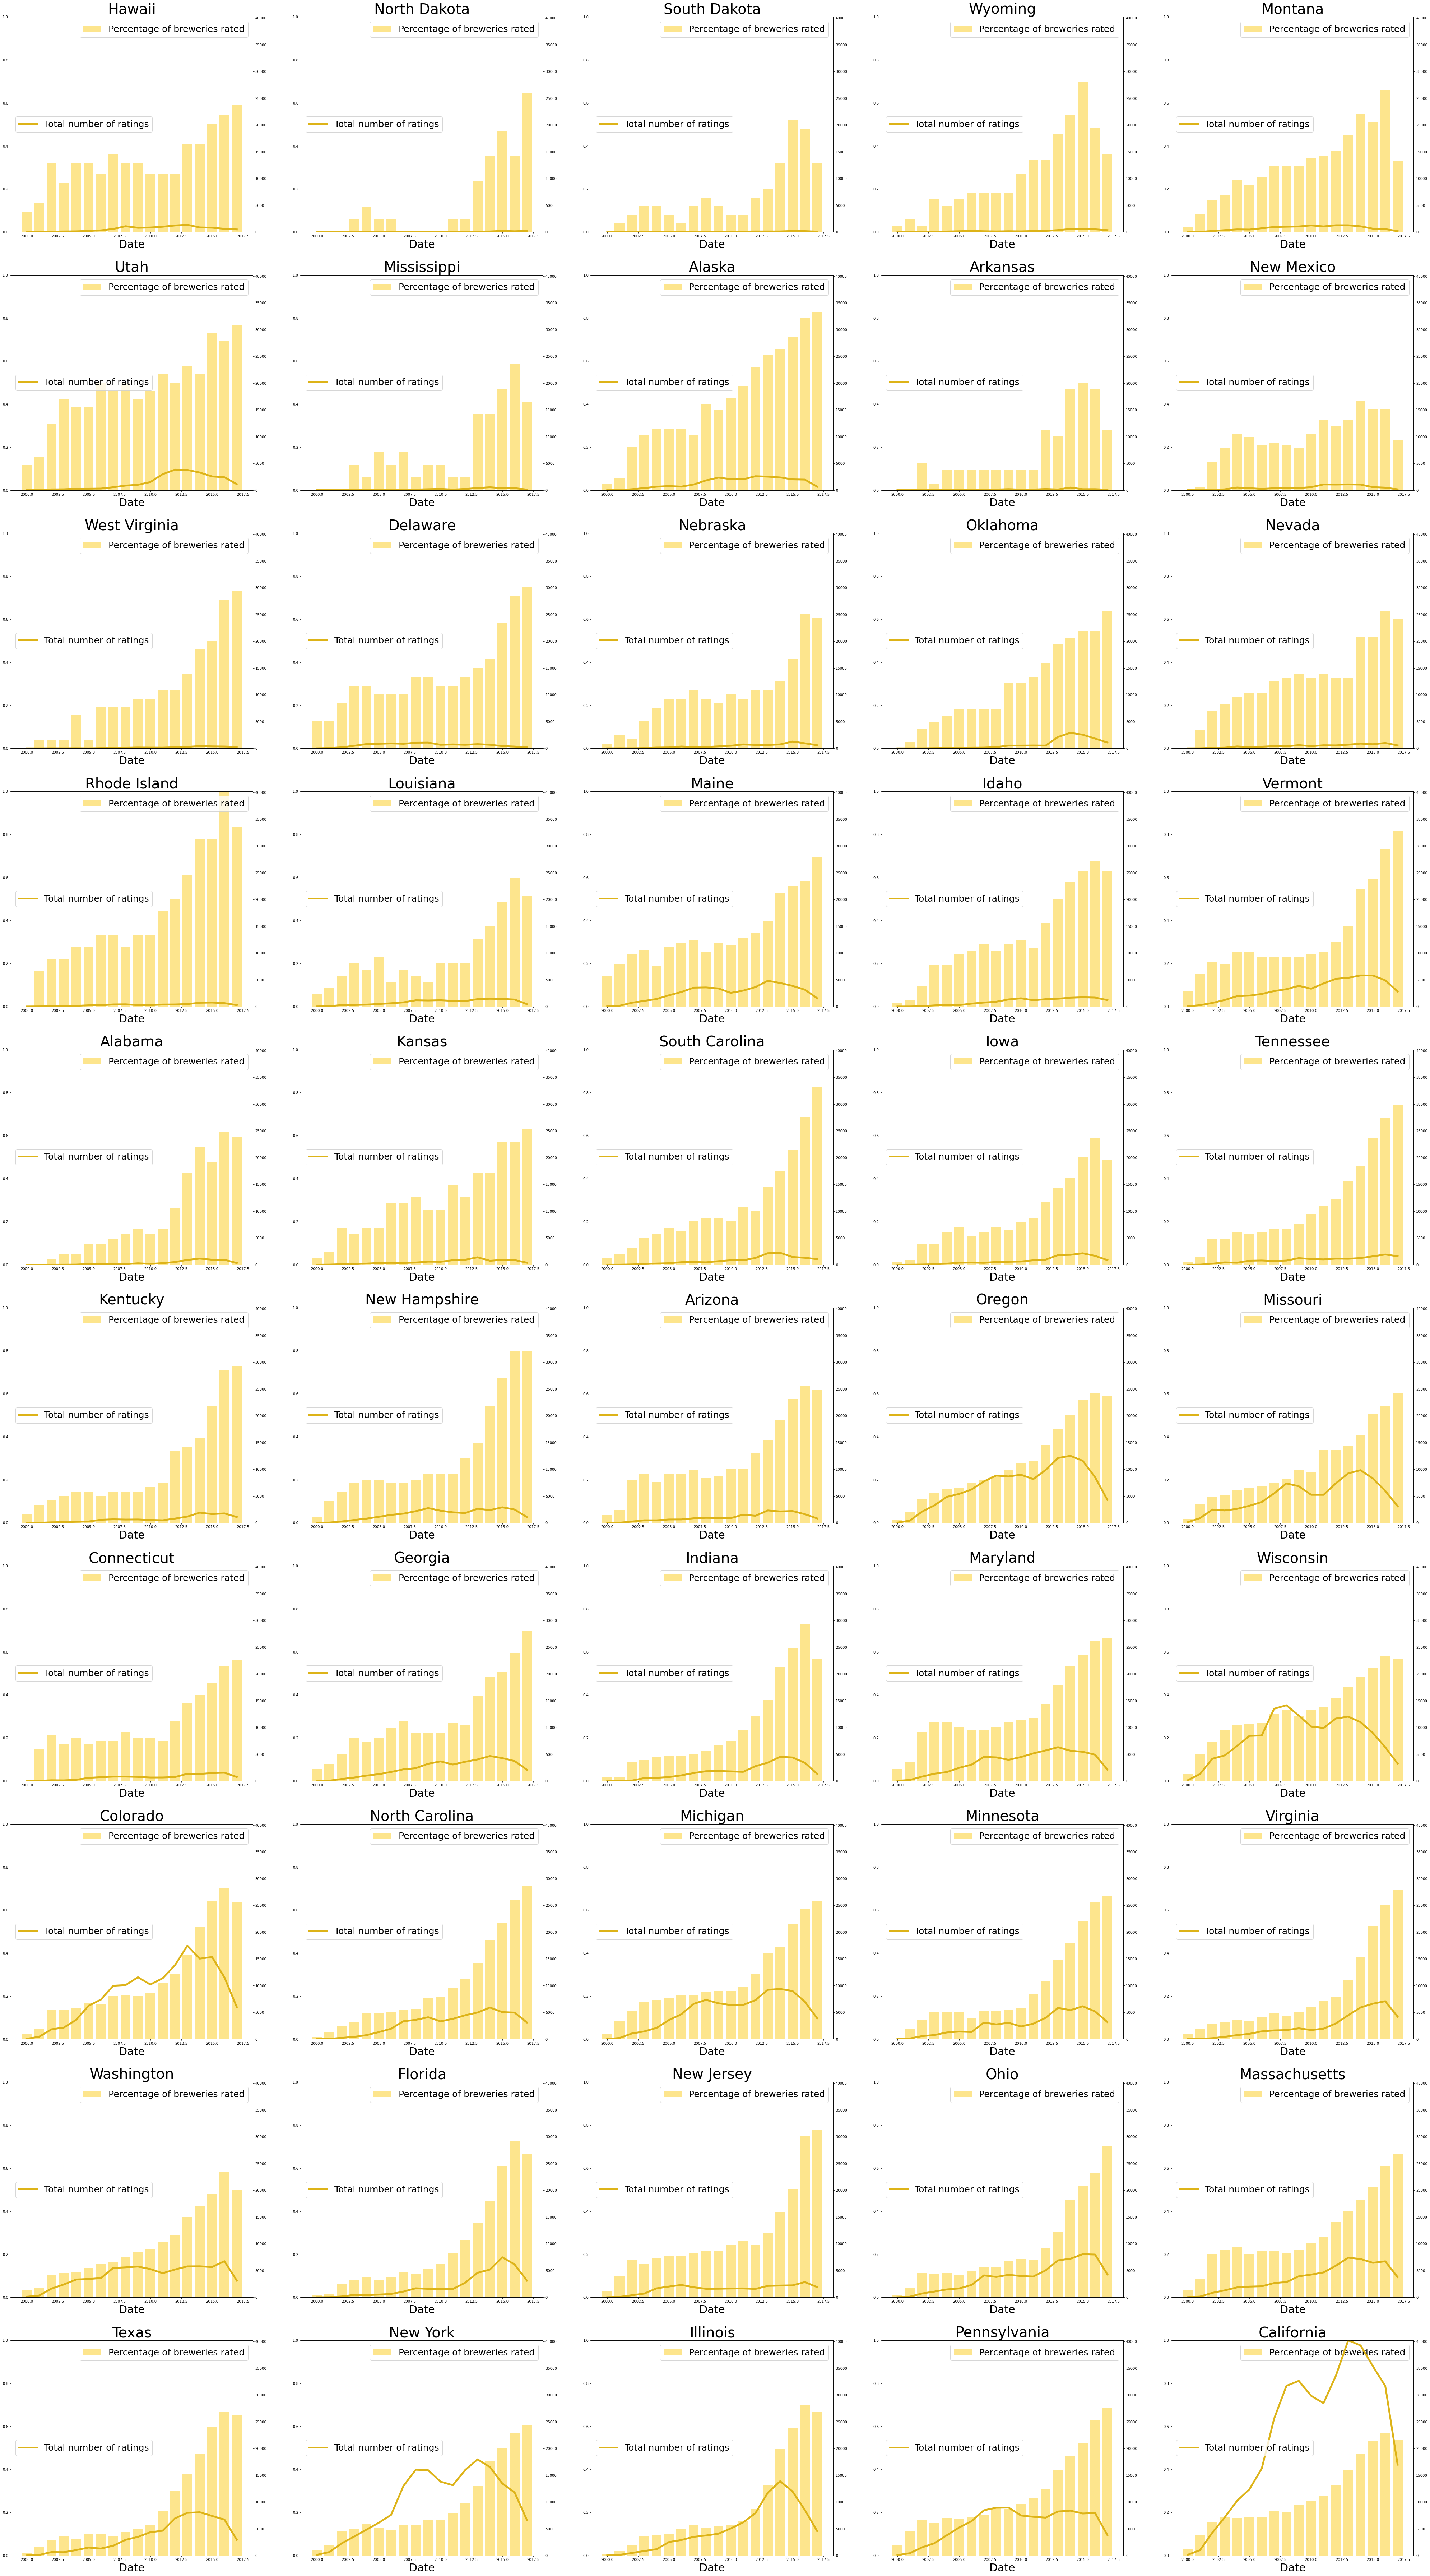

In [146]:
# Plot the evolution of ratings per breweries through the years
fig, axs = plt.subplots(10, 5, figsize=(70,130))

min_year = ratings_US_rb['year'].min()
max_year = ratings_US_rb['year'].max()
year_range = [y for y in range(min_year, max_year+1)]

max_nbr_ratings = states_overview_df.describe().loc['max'][['total_nbr_ratings_' + str(y) for y in year_range]].max()

states = states_overview_df.index
for i in range(len(states)):
    # Get the info on the plot
    state = states[i]
    row = i // 5
    col = i % 5
    subplot = axs[row, col]
    subplot2 = subplot.twinx()
    
    # Get the list of points
    state_info = states_overview_df.loc[state]
    percentage = [state_info['percentage_breweries_rated_' + str(y)] for y in year_range]
    nbr_ratings = [state_info['total_nbr_ratings_' + str(y)] for y in year_range]
    
    # Plot the percentage of breweries rated 
    subplot.bar(year_range, percentage, color=shade1, alpha=0.5, label='Percentage of breweries rated')
    subplot.legend(fontsize=25, loc='upper right')
    subplot.set_ylim([0.0,1.0])
    
    # Plot the total number of ratings
    subplot2.plot(year_range, nbr_ratings, color=shade2, linewidth=5, label='Total number of ratings')
    subplot2.legend(fontsize=25, loc='center left')
    subplot2.set_ylim([0, max_nbr_ratings])
    
    subplot.set_xlabel("Date", fontsize=30)
    subplot.set_title(state, fontsize=40)

### Local breweries

Local breweries are very common in US. As US costumers seems to like those we will extract the breweries that do not have ratings from users elsewhere in the world.
<br>
In a second time, We will try to see through the years which breweries was local.

In [149]:
# Get the US breweries
states = list(set(states_rb).union(set(states_ba)))
breweries_US_rb = breweries_rb[breweries_rb['location'].isin(states)]
breweries_US_ba = breweries_ba[breweries_ba['location'].isin(states)]

# RateBeer
is_local_list = np.array(list())

for bi in breweries_US_rb['id']:
    # Get the beer ids
    beer_ids = beers_rb[beers_rb['brewery_id'] == bi]['beer_id'].unique()

    # See if the ratings are from local users
    user_ids = ratings_US_rb[ratings_US_rb['beer_id'].isin(beer_ids)]['user_id']
    user_locations = users_rb[users_rb['user_id'].isin(user_ids)]['location'].unique()
    is_local = (len(user_locations) == 1)
    
    # Add the local bool
    is_local_list = np.append(is_local_list, is_local)

# Add the column in the dataframe
breweries_US_rb['is_local'] = is_local_list


#Beer Advocate
is_local_list = np.array(list())

for bi in breweries_US_ba['id']:
    # Get the beer ids
    beer_ids = beers_ba[beers_ba['brewery_id'] == bi]['beer_id'].unique()

    # See if the ratings are from local users
    user_ids = ratings_US_ba[ratings_US_ba['beer_id'].isin(beer_ids)]['user_id']
    user_locations = users_ba[users_ba['user_id'].isin(user_ids)]['location'].unique()
    is_local = (len(user_locations) == 1)
    
    # Add the local bool
    is_local_list = np.append(is_local_list, is_local)

# Add the column in the dataframe
breweries_US_ba['is_local'] = is_local_list

<ipython-input-149-2e939649cef9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breweries_US_rb['is_local'] = is_local_list


In [157]:
# Now we can compute the number of local breweries per state
breweries_groupby_state_rb = breweries_US_rb.groupby('location')
breweries_groupby_state_ba = breweries_US_ba.groupby('location')

nbr_local_breweries = np.array(list())

for state in states_overview_df.index:
    complete_state = 'United States, ' + state
    state_breweries_rb = breweries_groupby_state_rb.get_group(complete_state)
    state_breweries_ba = breweries_groupby_state_ba.get_group(complete_state)
    
    nbr_local = state_breweries_rb[state_breweries_rb['is_local'] == 1].shape[0] + state_breweries_ba[state_breweries_ba['is_local'] == 1].shape[0]
    
    nbr_local_breweries = np.append(nbr_local_breweries, nbr_local)

states_overview_df['nbr_local_breweries'] = nbr_local_breweries

In [158]:
states_overview_df['percentage_local_breweries'] = states_overview_df['nbr_local_breweries'] / states_overview_df['nbr_breweries']

In [160]:
states_overview_df.head()

,nbr_ratings_rb,nbr_ratings_ba,total_nbr_ratings,average_ABV,average_overall,average_rating,nbr_breweries,percentage_breweries_rated_2000,total_nbr_ratings_2000,percentage_breweries_rated_2001,...,percentage_breweries_rated_2014,total_nbr_ratings_2014,percentage_breweries_rated_2015,total_nbr_ratings_2015,percentage_breweries_rated_2016,total_nbr_ratings_2016,percentage_breweries_rated_2017,total_nbr_ratings_2017,nbr_local_breweries,percentage_local_breweries
state,,,,,,,,,,,,,,,,,,,,,
Hawaii,2164.0,7897.0,10061.0,7.028508,6.965743,3.740738,47.0,0.090909,13.0,0.136364,...,0.409091,858.0,0.500000,811.0,0.545455,599.0,0.590909,483.0,5.0,0.106383
North Dakota,2771.0,7828.0,10599.0,6.765740,8.395969,3.664402,33.0,0.000000,0.0,0.000000,...,0.352941,100.0,0.470588,210.0,0.352941,133.0,0.647059,218.0,2.0,0.060606
South Dakota,1593.0,11709.0,13302.0,6.496917,5.661950,3.670636,51.0,0.000000,0.0,0.040000,...,0.320000,105.0,0.520000,190.0,0.480000,161.0,0.320000,75.0,5.0,0.098039
Wyoming,2373.0,11016.0,13389.0,7.002604,6.503762,3.725254,69.0,0.030303,3.0,0.060606,...,0.545455,556.0,0.696970,606.0,0.484848,504.0,0.363636,346.0,6.0,0.086957
Montana,5002.0,8670.0,13672.0,6.794669,8.770595,3.606620,154.0,0.024390,5.0,0.085366,...,0.548780,1064.0,0.512195,621.0,0.658537,548.0,0.329268,154.0,15.0,0.097403


##### Plot the percentage of local breweries per state

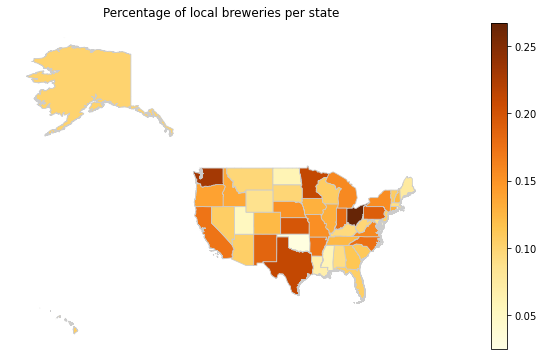

In [161]:
# Create column for the average ABV
merged = map_df.set_index('NAME_1').join(states_overview_df['percentage_local_breweries'])

# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage_local_breweries'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['percentage_local_breweries']), max(states_overview_df['percentage_local_breweries'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Percentage of local breweries per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [162]:
# See if the brewery was local for each year
states = list(set(states_rb).union(set(states_ba)))
breweries_US_rb = breweries_rb[breweries_rb['location'].isin(states)]

min_year = ratings_US_rb['year'].min()
max_year = ratings_US_rb['year'].max()

for y in range(min_year, max_year+1):
    ratings_year = ratings_US_rb_groupby_year.get_group(y)
    is_local_list = np.array(list())
    
    for bi in breweries_ratings_by_year_rb['id']:
        # Get the beer ids
        beer_ids = beers_rb[beers_rb['brewery_id'] == bi]['beer_id'].unique()
        
        # See if the ratings are from local users
        user_ids = ratings_year[ratings_year['beer_id'].isin(beer_ids)]['user_id']
        user_locations = users_rb[users_rb['user_id'].isin(user_ids)]['location'].unique()
        is_local = (len(user_locations) == 1)

        # Add the local bool
        is_local_list = np.append(is_local_list, is_local)
    
    # Add the column in the dataframe
    breweries_ratings_by_year_rb['is_local_' + str(y)] = is_local_list

In [164]:
breweries_ratings_by_year_rb_groupby_location = breweries_ratings_by_year_rb.groupby('location')

min_year = ratings_US_rb['year'].min()
max_year = ratings_US_rb['year'].max()

for y in range(min_year, max_year+1):
    nbr_local_breweries = np.array(list())
    
    # Compute for each state
    for state in states_overview_df.index:
        complete_state = 'United States, ' + state
        
        # Get the number of ratings evolution through years
        breweries_ratings_evolution = breweries_ratings_by_year_rb_groupby_location.get_group(complete_state)
        nbr_ratings_per_brewery = breweries_ratings_evolution['is_local_' + str(y)]

        # Compute the number of local breweries
        cpt = np.where(nbr_ratings_per_brewery == 1)[0].shape[0]
        
        # Add the results in the lists
        nbr_local_breweries = np.append(nbr_local_breweries, cpt)
        
    states_overview_df['nbr_local_breweries_' + str(y)] = nbr_local_breweries

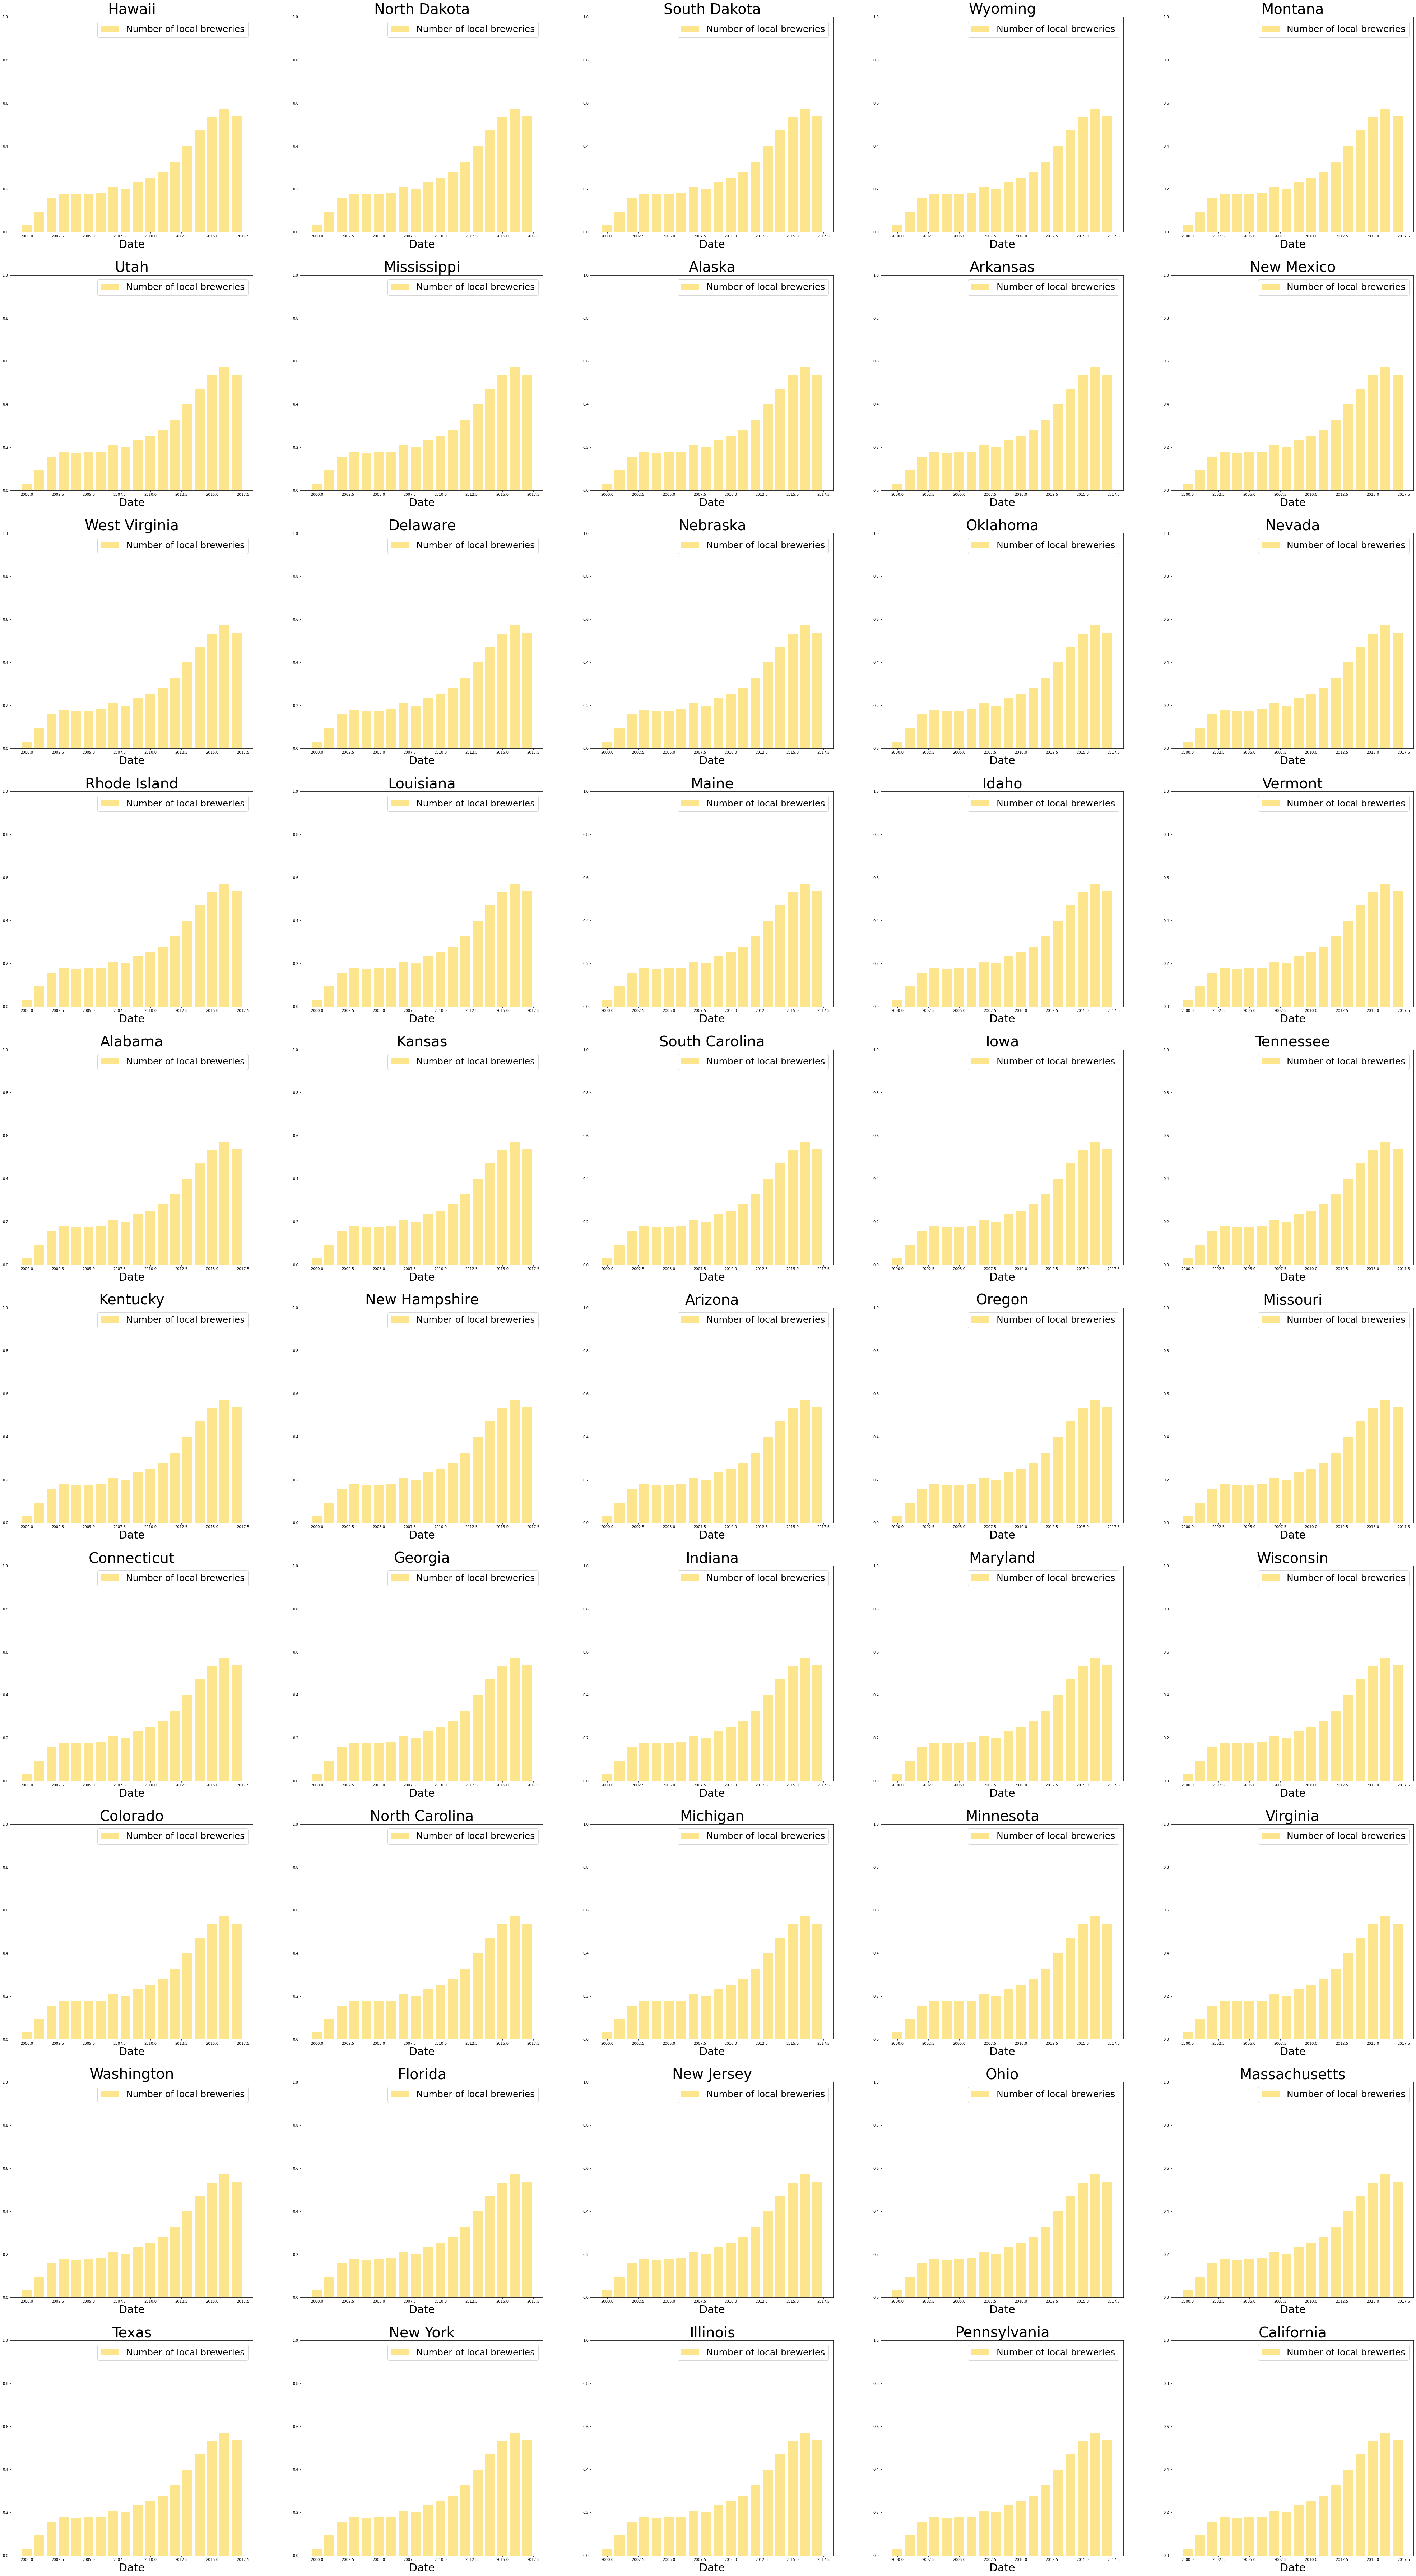

In [165]:
# Plot the evolution of ratings per breweries through the years
fig, axs = plt.subplots(10, 5, figsize=(70,130))

min_year = ratings_US_rb['year'].min()
max_year = ratings_US_rb['year'].max()
year_range = [y for y in range(min_year, max_year+1)]

max_nbr_ratings = states_overview_df.describe().loc['max'][['total_nbr_ratings_' + str(y) for y in year_range]].max()

states = states_overview_df.index
for i in range(len(states)):
    # Get the info on the plot
    state = states[i]
    row = i // 5
    col = i % 5
    subplot = axs[row, col]
    
    # Get the list of points
    state_info = states_overview_df.loc[state]
    nbr_local = [state_info['nbr_local_breweries_' + str(y)] for y in year_range]
    
    # Plot the percentage of breweries rated 
    subplot.bar(year_range, percentage, color=shade1, alpha=0.5, label='Number of local breweries')
    subplot.legend(fontsize=25, loc='upper right')
    subplot.set_ylim([0.0,1.0])
    
    subplot.set_xlabel("Date", fontsize=30)
    subplot.set_title(state, fontsize=40)

### Where to get a brewery ?

When someone want to open a new brewery in the US he should first think about the location.
<br>
Through the analyse of some specific attributes we will try to determine which states are the more relevant for opening a brewery.
<br>
First, lets look at the number of concurrent.

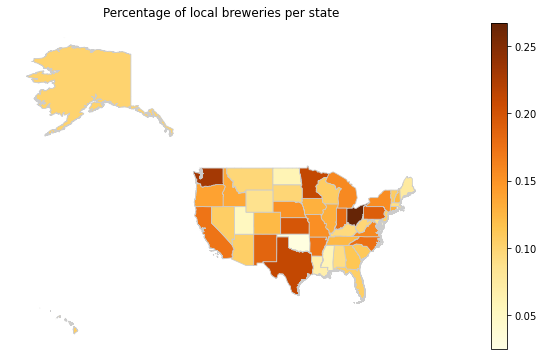

In [163]:
# Create column for the average ABV
merged = map_df.set_index('NAME_1').join(states_overview_df['percentage_local_breweries'])

# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage_local_breweries'
# set the range for the choropleth
vmin, vmax = min(states_overview_df['percentage_local_breweries']), max(states_overview_df['percentage_local_breweries'])
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 6))
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.8, ax=ax, edgecolor='0.8')

# Remove axis
ax.axis('off')
ax.set_title('Percentage of local breweries per state')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

On this map we can see the percentage of local breweries in each state. Firstly we can see that that percentage varies between about 5% and about 25% in the country. Then we see that the states with the smallest percentage of breweries are Oklahoma, Utah, Mississipi and Louisiane. 
<br><br>
In a second time we will find in which state user prefer local beers. Therefore, from users of each state we will see the percentage of ratings they gave about breweries in their state.

In [ ]:
# Get the US users
states = list(set(states_rb).union(set(states_ba)))
users_US_rb = users_rb[users_rb['location'].isin(states)]
users_US_ba = users_ba[users_ba['location'].isin(states)]

# RateBeer
percentage_local_ratings = np.array(list())

for i in range(users_US_rb.shape[0]):
    # Get the user info
    user = users_US_rb.iloc[i]
    ui = user['user_id']
    state = user['location']
    
    # Get the ratings
    ratings = ratings_US_rb[ratings_US_rb['user_id'] == ui]
    
    
    
    # Get the beer ids
    beer_ids = beers_rb[beers_rb['brewery_id'] == bi]['beer_id'].unique()

    # See if the ratings are from local users
    user_ids = ratings_US_rb[ratings_US_rb['beer_id'].isin(beer_ids)]['user_id']
    user_locations = users_rb[users_rb['user_id'].isin(user_ids)]['location'].unique()
    is_local = (len(user_locations) == 1)
    
    # Add the local bool
    is_local_list = np.append(is_local_list, is_local)

# Add the column in the dataframe
breweries_US_rb['is_local'] = is_local_list